In [2]:
# For Google Colaboratory
import sys, os

if "google.colab" in sys.modules:
    # mount google drive
    from google.colab import drive

    drive.mount("/content/gdrive")
    path_to_file = "/content/gdrive/My Drive/LLIE_Project"
    print(path_to_file)

    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/LLIE_Project
/content/gdrive/My Drive/LLIE_Project


In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
from tqdm import tqdm

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from DatasetAndAugmentation.LowHighDataAugment import PairedTransforms
from DatasetAndAugmentation.LowHightDataset import LOLPairedDataset
import matplotlib.pyplot as plt
from model.model import RELLIE

try:
    from torchmetrics import StructuralSimilarityIndexMeasure
except:
    !pip install torchmetrics
    from torchmetrics import StructuralSimilarityIndexMeasure

import torch
import torch.nn as nn
from torch.optim import AdamW, Adam, SGD

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Define the dir of the dataset

In [5]:
# direction of the dataset
dataset_dir = "/path/to/dataset"
# directory of low-light images
train_low_dir = "./LOLdataset/train/low"
# directory of high-light images
train_bright_dir = "./LOLdataset/train/high"

# test
test_low_dir = "./LOLdataset/test/low"
test_bright_dir = "./LOLdataset/test/high"

# create the train/test pic transformer, dataset and dataLoader

In [6]:
# create transform class to transform the image into tensor
train_batch_size = 2
train_transform = PairedTransforms(image_size=(400, 600), train=True)
train_dataset = LOLPairedDataset(
    train_low_dir, train_bright_dir, transform=train_transform, train=True
)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)


test_transform = PairedTransforms(image_size=(400, 600), train=False)
test_dataset = LOLPairedDataset(
    test_low_dir, test_bright_dir, transform=train_transform, train=False
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the model

In [7]:
model = RELLIE().to(device)
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)


class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, reduction="elementwise_mean"):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(
            data_range=1.0,  # For normalized images [0,1]
            kernel_size=window_size,
            reduction=reduction,
        )

    def forward(self, img1, img2):
        """
        Compute SSIM loss between two images.

        Args:
            img1: Output from RetinexNet (range ~[-1,1] after MeanShift)
            img2: Ground truth (range [0,1])

        Returns:
            loss: 1 - SSIM (higher is worse)
        """
        # Normalize Retinex output to [0,1] if needed
        if torch.min(img1) < 0:
            img1 = (img1 + 1) / 2  # Convert [-1,1] to [0,1]

        # Ensure both images are float32 and in [0,1]
        img1 = img1.float().clamp(0, 1)
        img2 = img2.float().clamp(0, 1)

        return 1 - self.ssim(img1, img2)  # Lower is better


mse_loss = nn.MSELoss()
ssim_loss = SSIMLoss(window_size=11).to(device)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [8]:
torch.cuda.memory_allocated()

8280064

# Pipline of training Process

In [9]:
def train_one_epoch(model, train_loader, optimizer, epoch=0):
    running_total = 0
    running_attn = 0
    running_ref = 0
    running_dec = 0
    running_rest = 0
    num_batches = 0
    for batch in tqdm(train_loader):
        input_low_light = batch["low"].to(device)
        target_high_light = batch["bright"].to(device)
        # forward
        (
            input_low_light_attn,
            target_high_light_attn,
            reflectance_low_light,
            reflectance_high_light,
            illumination_low_light,
            illumination_high_light,
            enhanced_illumination,
            enhanced_reflectance,
        ) = model(input_low_light, target_high_light, "train")

        # calculate loss

        ## sanity check
        assert input_low_light_attn.shape == target_high_light_attn.shape
        assert reflectance_low_light.shape == reflectance_high_light.shape
        assert illumination_low_light.shape == illumination_high_light.shape
        assert reflectance_high_light.shape == target_high_light.shape

        print(input_low_light_attn.size(), target_high_light_attn.size())
        print(target_high_light_attn)
        attn_extraction_loss = mse_loss(input_low_light_attn, target_high_light_attn)
        #print(attn_extraction_loss)
        decomposition_loss = ssim_loss(
            reflectance_high_light * illumination_high_light, target_high_light
        ) + ssim_loss(reflectance_low_light * illumination_low_light, input_low_light)

        #print(decomposition_loss)
        reflectance_loss = ssim_loss(reflectance_low_light, reflectance_high_light)

        # illumination_enhance_loss = ssim_loss(
        #     enhanced_illumination, illumination_high_light
        # )
        # reflectance_enhance_loss = ssim_loss(
        #     enhanced_reflectance, reflectance_high_light
        # )
        restoration_loss = ssim_loss(
            enhanced_reflectance * enhanced_illumination, target_high_light
        )

        total_loss = (
            100 * restoration_loss
            + 10 * decomposition_loss
             + 10 * reflectance_loss
             + 5 * attn_extraction_loss
            # + 10 * illumination_enhance_loss
            # + 10 * reflectance_enhance_loss
        )

        running_attn += attn_extraction_loss.detach().item()
        running_dec += decomposition_loss.detach().item()
        running_ref += reflectance_loss.detach().item()
        # running_enh_ill += illumination_enhance_loss.detach().item()
        # running_enh_refl += reflectance_enhance_loss.detach().item()
        running_rest += restoration_loss.detach().item()
        running_total += total_loss.detach().item()

        # backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        num_batches += 1

    print(
        f"Epoch {epoch + 1}:\t Total Loss = {running_total / num_batches}\t restoration_loss = {running_rest / num_batches}\t d_loss = {running_dec / num_batches}\t r_loss = {running_ref / num_batches}\t attn_loss = {running_attn / num_batches}\t "
    )


def evaluate(model, test_loader):
    running_total = 0
    num_batches = 0
    with torch.no_grad():
        for batch in test_loader:
            input_low_light = batch["low"].to(device)
            target_high_light = batch["bright"].to(device)

            # forward
            predict_high_light = model(input_low_light, None, "eval")

            loss = ssim_loss(predict_high_light, target_high_light)
            running_total += loss.item()
            num_batches += 1

    print(f"Evaluation on test set: SSIM Loss = {running_total / num_batches}")

In [ ]:
model_dict_folder = "./model_files_ADAM_2"
if not os.path.exists(model_dict_folder):
    os.makedirs(model_dict_folder)

starting_epoch = 0
load_model = False

if load_model:
    model.load_state_dict(
        torch.load(f"epoch_{starting_epoch}_state.pt"), weights_only=True
    )

for epoch in range(starting_epoch, 200):
    if epoch % 20 == 1:
        lr = lr / 2
        optimizer = Adam(model.parameters(), lr=lr)

    train_one_epoch(model, train_loader, optimizer, epoch)
    torch.save(
        model.state_dict(), os.path.join(model_dict_folder, f"epoch_{epoch}_state.pt")
    )
    evaluate(model, test_loader)

  0%|          | 0/243 [00:00<?, ?it/s]

# Visualize the output of model

In [ ]:
load_model = False

if load_model:
    model.load_state_dict(
        torch.load("./model_files/epoch_13_state.pt", map_location=torch.device("cpu"))
    )

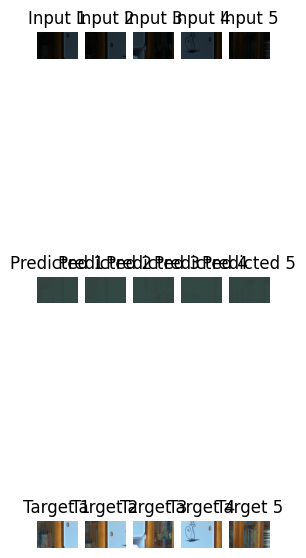

In [ ]:
num_images_show = 5
fig, axes = plt.subplots(3, num_images_show, figsize=(3 * train_batch_size, 9))
for i in range(num_images_show):
    batch = next(iter(test_loader))
    input_low_light = batch["low"].to(device)
    # print(input_low_light)
    target_high_light = batch["bright"].squeeze(0).to(device)

    # print(target_high_light)
    with torch.no_grad():
        predict_high_light = model(input_low_light, None, "eval").squeeze(0)

    predict_high_light_PIL, target_high_light_PIL = train_transform.tensor2PIL(
        predict_high_light, target_high_light
    )
    input_low_light_PIL, _ = train_transform.tensor2PIL(
        input_low_light.squeeze(0), None
    )

    # 第1行: Picture input into the model
    axes[0, i].imshow(input_low_light_PIL)
    axes[0, i].set_title(f"Input {i+1}")
    axes[0, i].axis("off")

    # 第2行: Picture output from the model, augmented by the model
    axes[1, i].imshow(predict_high_light_PIL)
    axes[1, i].set_title(f"Predicted {i+1}")
    axes[1, i].axis("off")

    # 第3行：The target picture
    axes[2, i].imshow(target_high_light_PIL)
    axes[2, i].set_title(f"Target {i+1}")
    axes[2, i].axis("off")
plt.show()